Лабораторная работа №4

1. Загрузка данных из файла tmdb_5000_movies.csv. Понадобятся только
столбцы original_title и overview. Есть несколько фильмов без какого
либо описания – их нужно удалить.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./tmdb_5000_movies.csv', sep=',', encoding='utf-8')
df = df[['original_title', 'overview']]
df = df.dropna()

2. Предобработка текстов:

a. Очистить тексты от лишних символов (оставить только слова).

In [4]:
import string
import nltk

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)

    text_without_punct = text.translate(translator)

    return text_without_punct

In [5]:
df['overview'] = df['overview'].apply(remove_punctuation)

c. Привести все в нижний регистр.

In [6]:
df['overview'] = df['overview'].str.lower()

d. Очистить от стоп-слов (служебные части речи, можно удалить часто употребимые слова из набора stopwords)

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

tokenized_doc = df['overview'].apply(lambda x: x.split())

tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop])

b. Лемматизировать (используя библиотеку NLTK определяйте еще и часть речи слова 
<p><font color='green'>Альтернативный вариант: используйте библиотеку spacy для лемматизации</font></p>

In [8]:
%pip install spacy
!spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

def lemmatize_and_pos(text):
    doc = nlp(text)
    
    lemmas = [token.lemma_ for token in doc]
    pos_tags = [token.pos_ for token in doc]

    return lemmas, pos_tags

In [10]:
df['lemmas'], df['pos'] = zip(*df['overview'].apply(lemmatize_and_pos))

df['lemmas'] = df['lemmas'].apply(lambda x: ' '.join(x))

3 Векторизация текстов. Используйте библиотеку scikit-learn и класс TfidfVectorizer. Метод fit_transform принимает корпус текстов и преобразует его в матричное представление, где строки представляют тексты, а столбцы – все встречающиеся в этих текстах слова. Для каждого слова в тексте определяется его метрика TF-IDF.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(df['lemmas'])

4. Отображение векторов текстов в двухмерном пространстве. Используйте метод t-SNE, который позволяет уменьшить размерность векторов до необходимой. Метод также реализован в библиотеке scikit- learn в виде класса TSNE. Получившиеся преобразованные векторы отобразить любой библиотекой для визуализации.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, init='random')
X_tsne = tsne.fit_transform(tfidf_matrix)

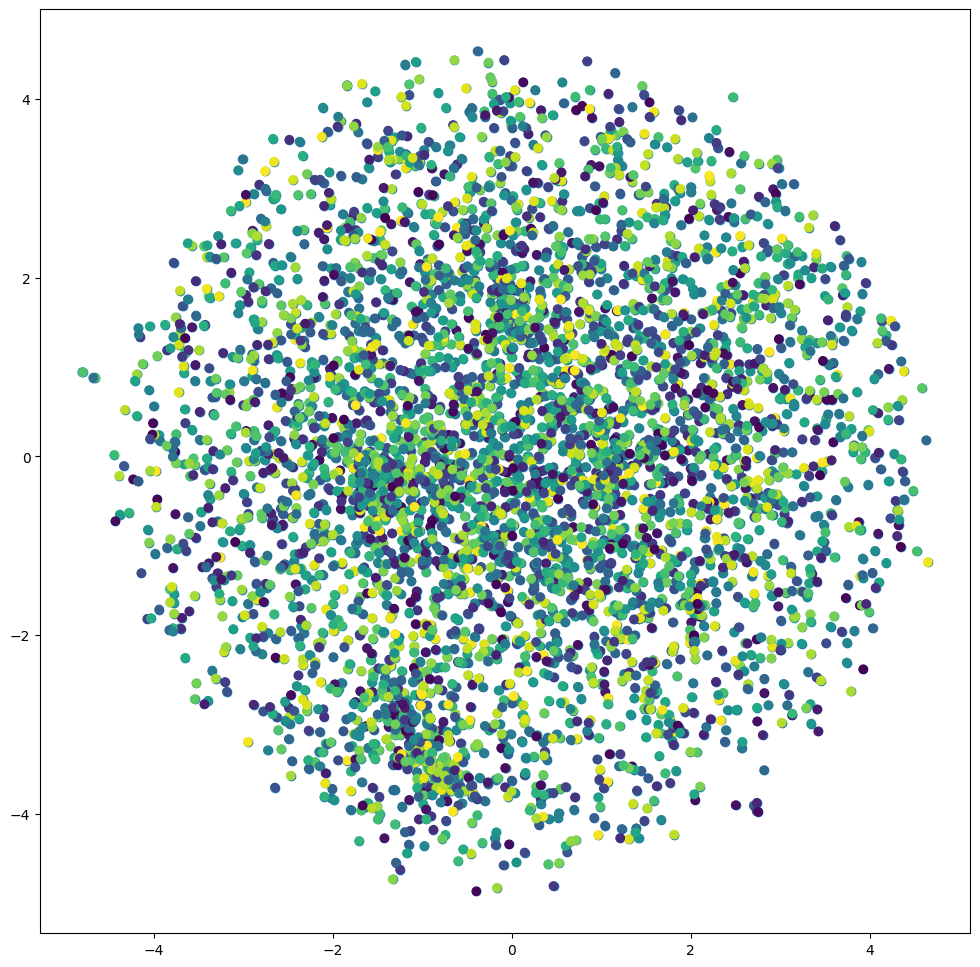

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
colors = np.random.rand(len(df))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)
plt.show()


5. Реализовать функционал для поиска похожих текстов. Для этого необходимо сравнивать векторы с помощью косинусной меры сходства векторов. Она также есть в виде метода cosine_similarity в библиотеке scikit-learn. Чем ближе два вектора, тем более похожие тексты, представляемые этими векторами. Косинусное сходство определяется в диапазоне от 0 до 1, от наименее схожих к наиболее схожим соответственно. Для примеров поиска брать фильмы из имеющихся данных. 
<p><font color='green'>Альтернативный вариант: взять новый фильм (описание фильма на английском языке можно отыскать на сайте IMDB) и векторизовать его (используя тот же векторизатор, что использовался для векторизации текстов из файла (метод transform)).</font></p>

In [14]:
new_film = {
    'original_title': "Kingsman: The Golden Circle",
    'overview': "After the Kingsman's headquarters is destroyed and the world is held hostage, an allied spy organization in the United States is discovered. These two elite secret agencies must band together to defeat a common enemy."
}

df_new_film = pd.DataFrame([new_film])

df_new_film['overview'] = df_new_film['overview'].apply(remove_punctuation)

df_new_film['overview'] = df_new_film['overview'].str.lower()

df_new_film['lemmas'], df_new_film['pos'] = zip(*df_new_film['overview'].apply(lemmatize_and_pos))

df_new_film['lemmas'] = df_new_film['lemmas'].apply(lambda x: ' '.join(x))

tfidf_matrix_new_film = tfidf.transform(df_new_film['lemmas'])

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(tfidf_matrix_new_film, tfidf_matrix).flatten()

Film_and_similarity = list(zip(df['original_title'], cosine_similarities))

Film_and_similarity.sort(key=lambda x: x[1], reverse=True)

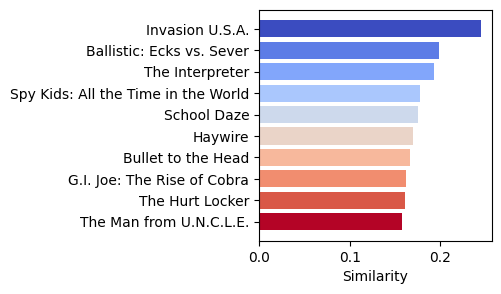

In [53]:
plt.figure(figsize=(3, 3))
plt.barh([x[0] for x in Film_and_similarity[:10]], [x[1] for x in Film_and_similarity[:10]], color=plt.cm.coolwarm(np.linspace(0, 1, 10)))
plt.gca().invert_yaxis()
plt.xlabel('Similarity')
plt.show()